### K均值聚类
步骤：
1. 随机选取K个中心点$u_1$,$u_2$,$u_3$,...,$u_k$（一般直接从数据源中选取）
2. 遍历所有点，找到离每个点最近的中心点$c^{(i)}(i=1,2,3,...,k)$
3. 重新计算中心点,$u_k=average(重新分配到k中心点的所有点)$
4. 重复2-3

### 作业1

In [5]:
import numpy as np
import sys
from matplotlib import pyplot as plt
from scipy import io as sio


def runKmeans(X, initial_centroids, K, max_iter = 1, plot_progeress=False):
    """
    X: array, shape=[rows,cols], 待聚类点，必须是二维
    initial_centroids: array, shape=[K, cols]，初始K个中心点
    return: tuple(centroids,idx)
        centroids, shape=[K, cols], 经过训练后的K个中心点
    """
    # 随机初始化K个聚类中心，这里根据吴恩达的数据直接指定
    if plot_progeress:
        plt.scatter(X[:,0], X[:, 1])
    centroids = initial_centroids
    idx = None
    for _ in range(max_iter):
        idx = findClosestCentroids(X, centroids)
        previous_centroids = centroids
        centroids = computeCentroids(X, idx, K)
        # 绘制KMeans聚类中心点移动过程
        if plot_progeress:
            plt.scatter(previous_centroids[:, 0], previous_centroids[:, 1], marker='x', color='r')
            plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='r')
    if plot_progeress:
        plt.show()
    return centroids,np.array(idx)


def findClosestCentroids(X, centroids):
    idx = []
    for _, x in enumerate(X):
        min_distance = sys.maxsize
        min_id = -1
        for j, o in enumerate(centroids):
            distance = np.dot((x - o), (x - o))
            if distance < min_distance:
                min_distance = distance
                min_id = j
        assert(min_id != -1)
        idx.append(min_id)
    return idx


def computeCentroids(X, idx, K=3):
    """
    X: array, shape=[rows,cols], 待聚类点，必须是二维
    idx: array, shape=[rows,] or [rows,1], 离X[i]最近的点centroids[idx[i]]
    """
    centroids = np.zeros((K, X.shape[1]))
    for _id, x in zip(idx, X):
        centroids[_id] += x
    for i in range(K):
        centroids[i] /= np.sum((np.array(idx) == i).astype(np.int32))
    return centroids

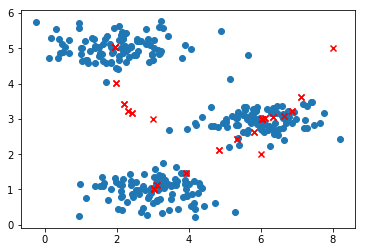

In [6]:
X = sio.loadmat('ex7data2.mat')['X']
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
K = 3
centroids,idx=runKmeans(X, initial_centroids, K, 
                        max_iter=10, plot_progeress=True)

### 作业2：使用KMeans进行图像压缩
1. `bird_small.png`包含了上万种颜色，通过聚类，用16种颜色来表示

In [7]:
from numpy import random
def initialize_random_centroids(X, K):
    return random.permutation(X[:K])

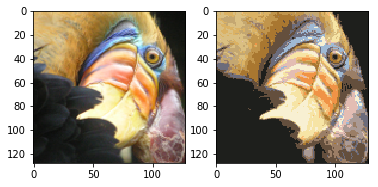

In [8]:
from matplotlib import image
fig,ax = plt.subplots(1,2)
ax1,ax2 = ax

img = image.imread('./bird_small.png')
ax1.imshow(img)
imgsize = img.shape
img = img.reshape((imgsize[0]*imgsize[1],3))

# KMeans Config
K = 16
max_iter = 10
centroids=initialize_random_centroids(img, K)
centroids,idx=runKmeans(img, centroids, K, max_iter=max_iter, plot_progeress=False)

img_recover = centroids[idx,:]
img_recover = img_recover.reshape((imgsize[0],imgsize[1],3))
ax2.imshow(img_recover)


# PCA
1.主要用途：
    1. 降维展示
    2. 加快训练速度
    3. 减少存储
2. 原理：
    1. 首先进行均值标准化：
    $$
        u_j=\frac{1}{m}\sum_{i=1}^{n} (x^{(i)})(x^{(i)})^T
    $$  
    然后计算sigma  
    $$
        sigma = \frac{1}{m}\sum_{i=1}^{m} (x^{(i)})(x^{(i)})^T  
    $$
    通常我们会有一个$X_{mxn}$，$x^{(i)}$为n维，共m个样本，此时我们可以利用矩阵运算的优势来加快迭代速度，即  
    $$
        sigma = \frac{1}{m}XX
    $$
    2. 降维  
    对第一步计算的sigma进行svd分解，即
    ```python
        from scipy.linalg import svd
        u,s,v = svd(X) 
        u_reduce = U(:,1:k)
    ```
    然后利用下列公式计算$z$：
    $$
        z = {U_{reduce}}^Tx^{(i)}
    $$
    同样，对于一个$X_{mxn}$，我们有：
    $$
        z = {U_{reduce}}^TX
    $$
    3. 压缩重现
    $$
        X' = UZ
    $$
3. 注意：不建议使用PCA去防止过拟合而应该使用正则项来处理这种情况！

### 作业1：数据降维展示

In [9]:
import numpy as np
from scipy.linalg import svd


def pca(X):
    """
    X: np.ndarray, shape=(n, m)
       每一列为样本数据
    """
    n, m = X.shape
    S = np.dot(X, X.T) / m
    U,_,_ = svd(S) # shape=(n,n)
    return U,S

def projectData(X, U, K):
    """
      降维
    """
    U = U[:,:K]  # shape=(n,k)
    # (m,n) dot (n,k)
    # => (m,k)
    z = np.dot(X.T, U)
    return z

def recoverData(Z, U, K):
    U = U[:,:K]  # shape=(n,k)
    return np.dot(U, Z.T)

def featureNormalize(X):
    mu = X.mean(0)
    X_norm = X - mu
    sigma = X.std(0)
    X_norm = X_norm / sigma
    return X_norm, mu, sigma

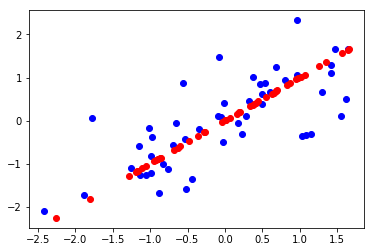

In [10]:
from scipy import io as sio
from matplotlib import pyplot as plt
%matplotlib inline

X = sio.loadmat('ex7data1.mat')['X']
X_norm, mu, sigma = featureNormalize(X)
plt.plot(X_norm[:,0], X_norm[:,1], 'bo')

U, S = pca(X_norm)
K = 1
Z = projectData(X_norm, U, K)
X_rec  = recoverData(Z, U, K)
plt.plot(X_rec[:, 0], X_rec[:, 1], 'ro')

从上图可以看到，当我们将数据降至一维时在还原时，我们的数据已经近似直线排列（红）

### 作业2：数据压缩

In [18]:
from matplotlib import pyplot as plt
import numpy as np

def displayData(X, width):
    m,n = X.shape
    hight = m // width
    piex = int(np.sqrt(n))
    
    cur = 0
    img = np.ones((width*piex + width+1,
                   hight*piex + hight+1))

    for i in range(hight):
        for j in range(width):
            x = (i+1)+(i)*piex-1
            y = (j+1)+(j)*piex-1
            img[x:x+piex,y:y+piex] = X[cur].reshape((piex,piex)) / X[cur].max()
            cur += 1
    return plt.imshow(img.T, cmap='gray')

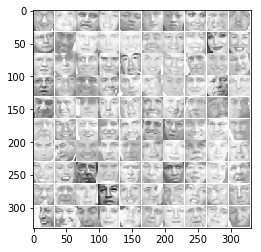

In [12]:
from scipy import io as sio
from matplotlib import pyplot as plt
X = sio.loadmat('ex7faces.mat')['X']
img = displayData(X[:100], 10)

In [13]:
[X_norm, mu, sigma] = featureNormalize(X)
[U, S] = pca(X_norm)

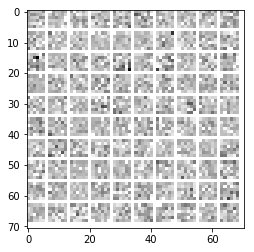

In [21]:
displayData(U[:100,:36], 10)

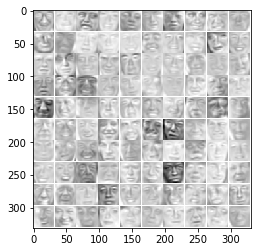

In [25]:
K = 100
Z = projectData(X, U, K)
X_rec  = recoverData(Z, U, K)
displayData(X_rec[:100,:], 10)